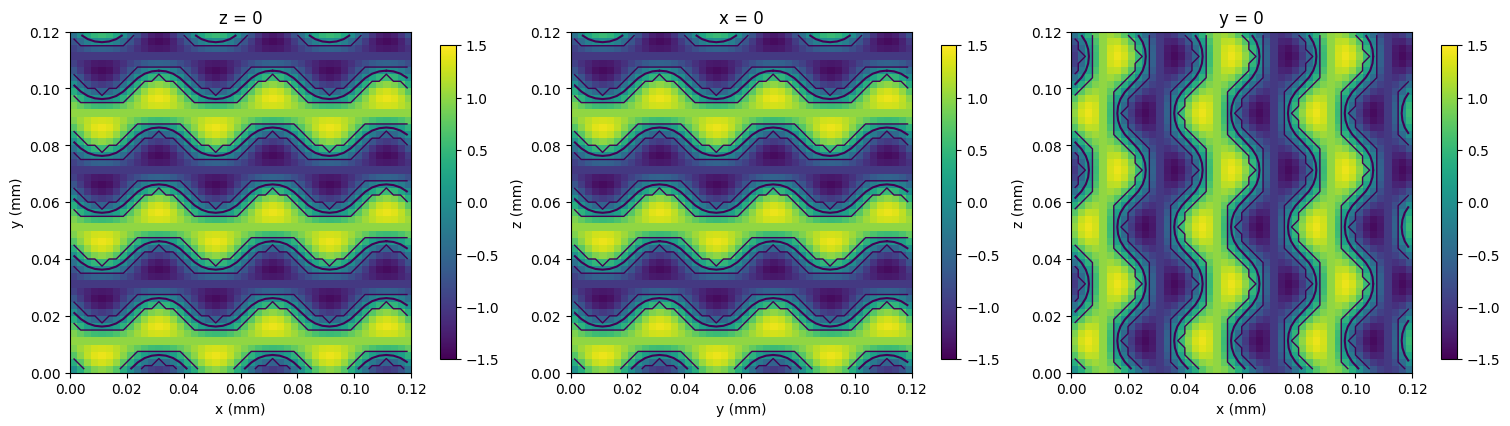

In [ ]:
import sys, subprocess, importlib, os
def ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
for p in ["numpy", "matplotlib", "scikit-image"]:
    ensure(p)

import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

tpmsType = "gyroid"
nxCells, nyCells, nzCells = 3, 3, 3
cellUm = 40.0
voxelsPerCell = 16
mode = "sheet"
sheetThicknessUm = 5
sheetThicknessMm = sheetThicknessUm/1000
tauOverride = 0.0

stlPath = f"tpms_{tpmsType}_{nxCells}x{nyCells}x{nzCells}_{int(cellUm)}um.stl"
pngPath = f"{tpmsType}_slice.png"

def fTpms(u, v, w, kind):
    X, Y, Z = 2*np.pi*u, 2*np.pi*v, 2*np.pi*w
    k = kind.lower()
    if k == "gyroid":
        return np.sin(X)*np.cos(Y) + np.sin(Y)*np.cos(Z) + np.sin(Z)*np.cos(X)
    if k == "schwarz_p":
        return np.cos(X) + np.cos(Y) + np.cos(Z)
    if k == "schwarz_d":
        return (np.sin(X)*np.sin(Y)*np.sin(Z)
               +np.sin(X)*np.cos(Y)*np.cos(Z)
               +np.cos(X)*np.sin(Y)*np.cos(Z)
               +np.cos(X)*np.cos(Y)*np.sin(Z))
    if k == "iwp":
        return np.cos(X)*np.sin(Y) + np.cos(Y)*np.sin(Z) + np.cos(Z)*np.sin(X)
    if k == "neovius":
        return 3*(np.cos(X) + np.cos(Y) + np.cos(Z)) + 4*np.cos(X)*np.cos(Y)*np.cos(Z)
    if k == "lidinoid":
        return 2*(np.cos(X)*np.cos(Y) + np.cos(Y)*np.cos(Z) + np.cos(Z)*np.cos(X)) - (np.cos(2*X) + np.cos(2*Y) + np.cos(2*Z))
    if k == "split_p":
        return np.cos(X) + np.cos(Y) + np.cos(Z) - np.sin(X)*np.sin(Y)*np.sin(Z)
    if k == "fisher_koch_s":
        return np.cos(X) + np.cos(Y)*np.cos(Z) + np.sin(Y)*np.sin(Z)
    if k == "schoen_g":
        return (np.cos(X)*np.sin(Y) + np.cos(Y)*np.sin(Z) + np.cos(Z)*np.sin(X)
               -np.sin(X)*np.cos(Y) - np.sin(Y)*np.cos(Z) - np.sin(Z)*np.cos(X))
    if k == "double_gyroid":
        g1 = np.sin(X)*np.cos(Y) + np.sin(Y)*np.cos(Z) + np.sin(Z)*np.cos(X)
        g2 = np.sin(X)*np.sin(Y)*np.sin(Z) - np.cos(X)*np.cos(Y)*np.cos(Z)
        return g1*g2
    if k == "wrap":
        return np.cos(X+Y) + np.cos(Y+Z) + np.cos(Z+X)
    if k == "diamond_triply":
        return (np.cos(X+Y+Z) + np.cos(X-Y+Z) + np.cos(X+Y-Z) + np.cos(-X+Y+Z))
    raise ValueError("unknown")

Nx, Ny, Nz = nxCells*voxelsPerCell, nyCells*voxelsPerCell, nzCells*voxelsPerCell
cellMm = cellUm/1000.0
dx = dy = dz = cellMm/voxelsPerCell
Lx, Ly, Lz = nxCells*cellMm, nyCells*cellMm, nzCells*cellMm

x = np.linspace(0, nxCells, Nx, endpoint=False)
y = np.linspace(0, nyCells, Ny, endpoint=False)
z = np.linspace(0, nzCells, Nz, endpoint=False)
U, V, W = np.meshgrid(x%1.0, y%1.0, z%1.0, indexing="ij")
F = fTpms(U, V, W, tpmsType).astype(np.float32)
gx, gy, gz = np.gradient(F, dx, dy, dz, edge_order=2)
gradMag = np.sqrt(gx*gx + gy*gy + gz*gz).astype(np.float32)
tau = float(tauOverride)
solidMask = (np.abs(F - tau) <= 0.5*sheetThicknessMm*gradMag)

pad = 1
solidPad = np.pad(solidMask.astype(np.uint8), ((pad,pad),(pad,pad),(pad,pad)), mode="constant", constant_values=0)
verts, faces, normals, values = marching_cubes(solidPad.astype(np.float32), level=0.5, spacing=(dx,dy,dz))
verts = verts - np.array([pad*dx, pad*dy, pad*dz])

def writeAsciiStl(path, V, Fidx, name="mesh", outward=True):
    with open(path, "w") as f:
        f.write(f"solid {name}\n")
        for tri in Fidx:
            a, b, c = (tri[0], tri[2], tri[1]) if outward else (tri[0], tri[1], tri[2])
            v1, v2, v3 = V[a], V[b], V[c]
            n = np.cross(v2 - v1, v3 - v1)
            n = n / (np.linalg.norm(n) + 1e-12)
            f.write(f"  facet normal {n[0]:.6e} {n[1]:.6e} {n[2]:.6e}\n")
            f.write("    outer loop\n")
            f.write(f"      vertex {v1[0]:.6e} {v1[1]:.6e} {v1[2]:.6e}\n")
            f.write(f"      vertex {v2[0]:.6e} {v2[1]:.6e} {v2[2]:.6e}\n")
            f.write(f"      vertex {v3[0]:.6e} {v3[1]:.6e} {v3[2]:.6e}\n")
            f.write("    endloop\n")
            f.write("  endfacet\n")
        f.write(f"endsolid {name}\n")

writeAsciiStl(stlPath, verts, faces, name=f"{tpmsType}_{mode}", outward=True)

def plotMesh(V, Fidx, elev=22, azim=35, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")
    mesh = Poly3DCollection(V[Fidx], alpha=0.85)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, Lx); ax.set_ylim(0, Ly); ax.set_zlim(0, Lz)
    ax.set_xlabel("X (mm)"); ax.set_ylabel("Y (mm)"); ax.set_zlabel("Z (mm)")
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout(); plt.show()

def showSlicesDashboard(F, Lx, Ly, Lz, tau=None, solidMask=None):
    vmin, vmax = float(F.min()), float(F.max())
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

    a_xy = F[:, :, 0].T
    im0 = ax[0].imshow(a_xy, origin="lower", extent=[0, Lx, 0, Ly], vmin=vmin, vmax=vmax, aspect="equal")
    ax[0].set_title("z = 0"); ax[0].set_xlabel("x (mm)"); ax[0].set_ylabel("y (mm)")
    if tau is not None and (a_xy.min() < tau < a_xy.max()):
        ax[0].contour(a_xy, levels=[tau], origin="lower", extent=[0, Lx, 0, Ly])
    if solidMask is not None:
        ax[0].contour(solidMask[:, :, 0].T.astype(float), levels=[0.5], origin="lower", extent=[0, Lx, 0, Ly], linewidths=1)

    a_yz = F[0, :, :].T
    im1 = ax[1].imshow(a_yz, origin="lower", extent=[0, Ly, 0, Lz], vmin=vmin, vmax=vmax, aspect="equal")
    ax[1].set_title("x = 0"); ax[1].set_xlabel("y (mm)"); ax[1].set_ylabel("z (mm)")
    if tau is not None and (a_yz.min() < tau < a_yz.max()):
        ax[1].contour(a_yz, levels=[tau], origin="lower", extent=[0, Ly, 0, Lz])
    if solidMask is not None:
        ax[1].contour(solidMask[0, :, :].T.astype(float), levels=[0.5], origin="lower", extent=[0, Ly, 0, Lz], linewidths=1)

    a_xz = F[:, 0, :].T
    im2 = ax[2].imshow(a_xz, origin="lower", extent=[0, Lx, 0, Lz], vmin=vmin, vmax=vmax, aspect="equal")
    ax[2].set_title("y = 0"); ax[2].set_xlabel("x (mm)"); ax[2].set_ylabel("z (mm)")
    if tau is not None and (a_xz.min() < tau < a_xz.max()):
        ax[2].contour(a_xz, levels=[tau], origin="lower", extent=[0, Lx, 0, Lz])
    if solidMask is not None:
        ax[2].contour(solidMask[:, 0, :].T.astype(float), levels=[0.5], origin="lower", extent=[0, Lx, 0, Lz], linewidths=1)

    for im, axi in zip([im0, im1, im2], ax):
        fig.colorbar(im, ax=axi, fraction=0.046, pad=0.04)

    plt.show()

# example call (gyroid sheet mid-surface at tau=0)
showSlicesDashboard(F, Lx, Ly, Lz, tau=0.0, solidMask=solidMask)


In [ ]:
def calcPorosity(solidMask, dx, dy, dz, Lx, Ly, Lz):
    voxelVol = dx*dy*dz
    totalVol = Lx*Ly*Lz
    solidVol = float(solidMask.sum())*voxelVol
    phi = 1.0 - solidVol/totalVol
    return phi, solidVol, totalVol

def solveTauForPhi(F, deltaTauField, targetPhi, lo, hi, iters=28):
    lo, hi = float(lo), float(hi)
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        solidMaskMid = (np.abs(F - mid) <= deltaTauField)
        phi = 1.0 - float(solidMaskMid.mean())
        if phi < targetPhi:
            lo = mid
        else:
            hi = mid
    return 0.5*(lo+hi)

def surfaceAreaFromMesh(verts, faces):
    v1 = verts[faces[:,0]]
    v2 = verts[faces[:,1]]
    v3 = verts[faces[:,2]]
    a = np.linalg.norm(np.cross(v2 - v1, v3 - v1), axis=1)*0.5
    return float(a.sum())

def volumeFromMesh(verts, faces):
    v1 = verts[faces[:,0]]
    v2 = verts[faces[:,1]]
    v3 = verts[faces[:,2]]
    vol = np.einsum("ij,ij->i", v1, np.cross(v2, v3))/6.0
    return float(vol.sum())

# use τ solver for sheets (optional)
if mode == "sheet" and tauOverride is None:
    Fmin, Fmax = float(F.min()), float(F.max())
    tau = solveTauForPhi(F, 0.5*sheetThicknessMm*gradMag, targetPorosity, Fmin+1e-6, Fmax-1e-6)
    tauClamped = float(np.clip(tau, Fmin+1e-6, Fmax-1e-6))
    solidMask = (np.abs(F - tauClamped) <= 0.5*sheetThicknessMm*gradMag)

phiVoxel, solidVolVoxel, totalVol = calcPorosity(solidMask, dx, dy, dz, Lx, Ly, Lz)

print("TPMS summary")
print("------------")
print(f"type: {tpmsType}")
print(f"mode: {mode}  (sheetThicknessMm={sheetThicknessMm:.3f})")
print(f"cells: {nxCells}x{nyCells}x{nzCells}  unit cell = {cellMm:.3f} mm")
print(f"grid: {Nx}x{Ny}x{Nz}  (voxels/cell={voxelsPerCell})")
print(f"domain (mm): {Lx:.3f} x {Ly:.3f} x {Lz:.3f}")
#print(f"tau: {tau:.6f}")
#print(f"STL: {os.path.abspath(stlPath)}")

print(f"\nPorosity:    {phiVoxel:.6f}")

print(f"Solid Volume mm3:  {solidVolVoxel:.6f}")
print(f"Total Volume mm3:  {totalVol:.6f}")

# if you already built verts/faces (after padding), you can also report mesh metrics
sa = surfaceAreaFromMesh(verts, faces)
volMesh = abs(volumeFromMesh(verts, faces))
print(f"Surface Area mm2:  {sa:.6f}")
#print(f"Volume Mesh mm3:   {volMesh:.6f}")


TPMS summary
------------
type: gyroid
mode: sheet  (sheetThicknessMm=0.005)
cells: 3x3x3  unit cell = 0.040 mm
grid: 48x48x48  (voxels/cell=16)
domain (mm): 0.120 x 0.120 x 0.120

Porosity:    0.661051
Solid Volume mm3:  0.000586
Total Volume mm3:  0.001728
Surface Area mm2:  0.291257


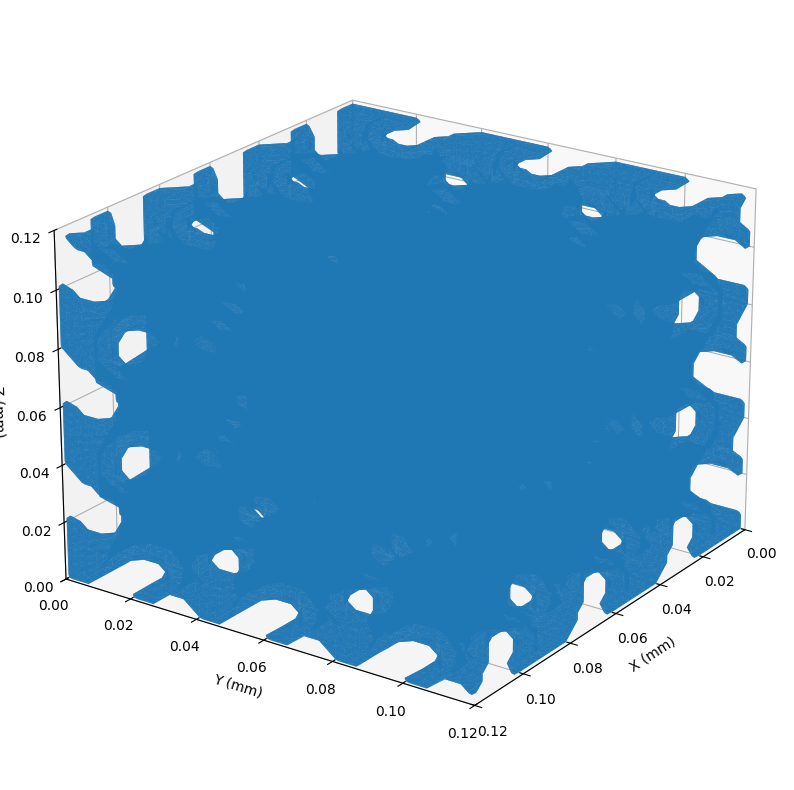

In [ ]:
plotMesh(verts, faces)

In [ ]:
####
####
####
#### Transition code (WIP)
####
####
####

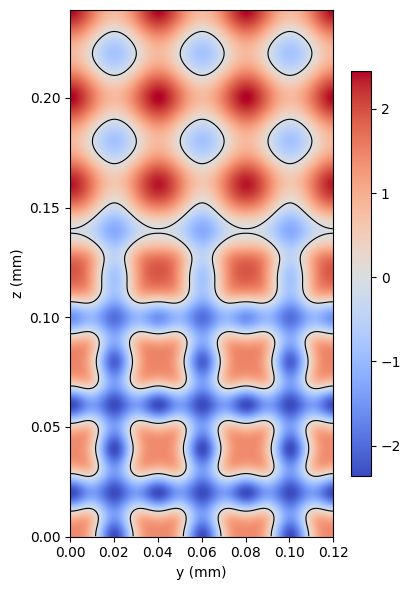

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def smoothstep01(t):
    t = np.clip(t, 0.0, 1.0)
    return t*t*(3 - 2*t)

nxCells, nyCells, nzCells = 3, 3, 6
voxelsPerCell = 96
cellUm = 40.0
cellMm = cellUm/1000.0
Nx, Ny, Nz = nxCells*voxelsPerCell, nyCells*voxelsPerCell, nzCells*voxelsPerCell
Lx, Ly, Lz = nxCells*cellMm, nyCells*cellMm, nzCells*cellMm

x = np.linspace(0, nxCells, Nx, endpoint=False)
y = np.linspace(0, nyCells, Ny, endpoint=False)
z = np.linspace(0, nzCells, Nz, endpoint=False)
U, V, W = np.meshgrid(x%1.0, y%1.0, z%1.0, indexing="ij")

tpmsA, tpmsB = "lidinoid", "schwarz_p"
z0, z1 = 0.25, 0.75

F1 = fTpms(U, V, W, tpmsA).astype(np.float32)
F2 = fTpms(U, V, W, tpmsB).astype(np.float32)
F1 /= (F1.std() + 1e-8)
F2 /= (F2.std() + 1e-8)

zFrac = np.linspace(0.0, 1.0, Nz, endpoint=False)
w = np.zeros_like(zFrac, dtype=np.float32)
m = (zFrac >= z0) & (zFrac <= z1)
w[zFrac > z1] = 1.0
w[m] = smoothstep01((zFrac[m] - z0) / (z1 - z0))
w = w[np.newaxis, np.newaxis, :]

Fblend = (1.0 - w) * F1 + w * F2

ix = 0
A = Fblend[ix, :, :].T

fig, ax = plt.subplots(figsize=(5,6))
im = ax.imshow(A, origin="lower",
               extent=[0, Ly, 0, Lz],
               aspect="equal", cmap="coolwarm")
ax.set_xlabel("y (mm)")
ax.set_ylabel("z (mm)")
ax.contour(A, levels=[0.0], colors="k", linewidths=0.8,
           origin="lower", extent=[0, Ly, 0, Lz])

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


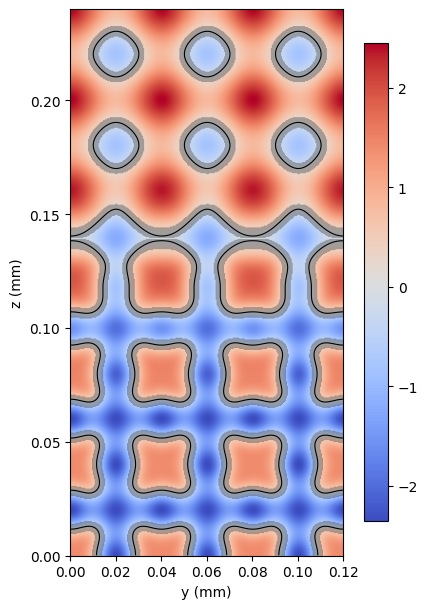

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def smoothstep01(t):
    t = np.clip(t, 0.0, 1.0)
    return t*t*(3 - 2*t)

# geometry setup
nxCells, nyCells, nzCells = 3, 3, 6     # number of unit cells in x, y, z
voxelsPerCell = 96                      # grid resolution per unit cell
cellUm = 40.0                           # unit cell size (microns)
cellMm = cellUm/1000.0                  # convert to millimeters
Nx, Ny, Nz = nxCells*voxelsPerCell, nyCells*voxelsPerCell, nzCells*voxelsPerCell
dx = dy = dz = cellMm/voxelsPerCell
Lx, Ly, Lz = nxCells*cellMm, nyCells*cellMm, nzCells*cellMm

x = np.linspace(0, nxCells, Nx, endpoint=False)
y = np.linspace(0, nyCells, Ny, endpoint=False)
z = np.linspace(0, nzCells, Nz, endpoint=False)
Xp, Yp, Zp = np.meshgrid(x, y, z, indexing="ij")

tpmsA, tpmsB = "lidinoid", "schwarz_p"

# morph parameters
z0, z1 = 0.25, 0.75                     # fractional z-range where morph occurs

# tapering parameters
taperK, taperP = 0, 1.0              # footprint taper strength & profile
sheetThicknessUm = 5.0                  # base sheet thickness in microns
sheetThicknessMm = sheetThicknessUm/1000.0
thicknessK, thicknessP = 0, 1.0      # top-lightening strength & profile

# isosurface parameter
tau = 0.0                               # implicit surface threshold

# apply footprint taper
cx, cy = nxCells/2.0, nyCells/2.0
zNorm = np.clip(Zp/nzCells, 0.0, 1.0)
s = 1.0 - taperK*(zNorm**taperP)
Xt = cx + (Xp - cx)*s
Yt = cy + (Yp - cy)*s

U = Xt%1.0
V = Yt%1.0
W = Zp%1.0

F1 = fTpms(U, V, W, tpmsA).astype(np.float32)
F2 = fTpms(U, V, W, tpmsB).astype(np.float32)
F1 /= (F1.std() + 1e-8)
F2 /= (F2.std() + 1e-8)

# blend field along z
zFrac = np.linspace(0.0, 1.0, Nz, endpoint=False)
w = np.zeros_like(zFrac, dtype=np.float32)
m = (zFrac >= z0) & (zFrac <= z1)
w[zFrac > z1] = 1.0
w[m] = smoothstep01((zFrac[m] - z0)/max(z1 - z0, 1e-8))
w = w[np.newaxis, np.newaxis, :]
Fblend = (1.0 - w)*F1 + w*F2

# thickness tapering with z
gx, gy, gz = np.gradient(Fblend, dx, dy, dz, edge_order=2)
gradMag = np.sqrt(gx*gx + gy*gy + gz*gz).astype(np.float32)
zIdx = np.arange(Nz)
zNorm1d = zIdx/max(Nz - 1, 1)
thicknessMmZ = sheetThicknessMm*(1.0 - thicknessK*(zNorm1d**thicknessP))
thicknessMmZ = np.clip(thicknessMmZ, 0.1*sheetThicknessMm, None)
thicknessMmZ = thicknessMmZ[np.newaxis, np.newaxis, :]
solidMask = (np.abs(Fblend - tau) <= 0.5*thicknessMmZ*gradMag)

# plot edge slice
ix = 0
A = Fblend[ix, :, :].T
M = solidMask[ix, :, :].T
fig, ax = plt.subplots(figsize=(5.8, 6.2))
im = ax.imshow(A, origin="lower", extent=[0, Ly, 0, Lz], aspect="equal", cmap="coolwarm")
ax.imshow(np.ma.masked_where(~M, M), origin="lower", extent=[0, Ly, 0, Lz], aspect="equal", cmap="gray_r", alpha=0.28, vmin=0, vmax=1)
ax.set_xlabel("y (mm)")
ax.set_ylabel("z (mm)")
ax.contour(A, levels=[tau], colors="k", linewidths=0.8, origin="lower", extent=[0, Ly, 0, Lz])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
